<a href="https://colab.research.google.com/github/diegorossi8/dio_ml_ia_dsa/blob/master/Diego_Rossi_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer learning / ajuste fino
Este tutorial irá guiá-lo pelo processo de usar o transfer learning (aprendizado por transferência) para aprender um classificador de imagem preciso a partir de um número relativamente pequeno de amostras de treinamento. Em termos gerais, transfer learning refere-se ao processo de alavancar o conhecimento aprendido em um modelo para o treinamento de outro modelo.

Mais especificamente, o processo envolve pegar uma rede neural existente que foi previamente treinada com bom desempenho em um conjunto de dados maior e usá-la como base para um novo modelo que aproveita a precisão da rede anterior para uma nova tarefa. Este método tornou-se popular nos últimos anos para melhorar o desempenho de uma rede neural treinada em um pequeno conjunto de dados; a intuição é que o novo conjunto de dados pode ser muito pequeno para alcançar um bom desempenho por si só, mas sabemos que a maioria das redes neurais treinadas para aprender características de imagem frequentemente aprendem características semelhantes de qualquer maneira, especialmente em camadas iniciais onde são mais genéricas (detectores de borda, manchas, e assim por diante).

O transfer learning foi largamente habilitado pela disponibilização de modelos de ponta de código aberto; para os modelos de melhor desempenho em tarefas de classificação de imagens (como os do ILSVRC), é prática comum agora não apenas publicar a arquitetura, mas também liberar os pesos treinados do modelo. Isso permite que amadores usem esses melhores classificadores de imagem para aumentar o desempenho de seus próprios modelos específicos de tarefa.

##Extração de características vs. ajuste fino
Em um extremo, o transfer learning pode envolver pegar a rede pré-treinada e congelar os pesos, e usar uma de suas camadas ocultas (geralmente a última) como extratora de características, usando essas características como entrada para uma rede neural menor.

No outro extremo, começamos com a rede pré-treinada, mas permitimos que alguns dos pesos (geralmente a última camada ou as últimas poucas camadas) sejam modificados. Outro nome para esse procedimento é "ajuste fino" porque estamos ajustando levemente os pesos da rede pré-treinada para a nova tarefa. Normalmente treinamos essa rede com uma taxa de aprendizado mais baixa, já que esperamos que as características já sejam relativamente boas e não precisem ser alteradas muito.

Às vezes, fazemos algo intermediário: Congelamos apenas as camadas iniciais/genéricas, mas ajustamos fino as camadas posteriores. Qual estratégia é melhor depende do tamanho do seu conjunto de dados, do número de classes e de quanto ele se assemelha ao conjunto de dados no qual o modelo anterior foi treinado (e, portanto, se pode se beneficiar dos mesmos extratores de características aprendidos). Uma discussão mais detalhada sobre como planejar estratégias pode ser encontrada em [1] [2].

##Procedimento
Neste guia, passaremos pelo processo de carregar um classificador de imagem de 1000 classes de ponta, VGG16, que venceu o desafio ImageNet em 2014, e usá-lo como um extrator de características fixo para treinar um classificador personalizado menor em nossas próprias imagens, embora com poucas mudanças de código, você também possa tentar o ajuste fino.

Primeiro, carregaremos o VGG16 e removeremos sua camada final, a camada de classificação softmax de 1000 classes específica para o ImageNet, e a substituiremos por uma nova camada de classificação para as classes sobre as quais estamos treinando. Em seguida, congelaremos todos os pesos na rede, exceto os novos conectados à nova camada de classificação, e então treinaremos a nova camada de classificação sobre nosso novo conjunto de dados.

Também compararemos este método ao treinamento de uma pequena rede neural do zero no novo conjunto de dados e, como veremos, isso melhorará dramaticamente nossa precisão. Faremos essa parte primeiro.

Como nosso objeto de teste, usaremos um conjunto de dados consistindo de cerca de 6000 imagens pertencentes a 97 classes e treinaremos um classificador de imagens com cerca de 80% de precisão nele. Vale ressaltar que esta estratégia se adapta bem a conjuntos de imagens onde você pode ter apenas algumas centenas ou menos de imagens. Seu desempenho será menor a partir de um número pequeno de amostras (dependendo das classes), como de costume, mas ainda impressionante considerando as limitações usuais.


In [ ]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

### Getting a dataset

O primeiro passo será carregar nossos dados. Como exemplo, estaremos usando o conjunto de dados CalTech-101, que contém cerca de 9000 imagens rotuladas pertencentes a 101 categorias de objetos. No entanto, excluiremos 5 das categorias que têm mais imagens. Isso é para manter a distribuição de classes bastante equilibrada (cerca de 50-100) e limitada a um número menor de imagens, em torno de 6000.

Para obter este conjunto de dados, você pode executar o script de download download.sh na pasta data, ou os seguintes comandos:

arduino
Copy code
wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
tar -xvzf 101_ObjectCategories.tar.gz
Se desejar usar seu próprio conjunto de dados, ele deve ser organizado da mesma forma para 101_ObjectCategories, com todas as imagens organizadas em subpastas, uma para cada classe. Nesse caso, a célula a seguir deve carregar seu conjunto de dados personalizado corretamente apenas substituindo root pela sua pasta. Se você tiver uma estrutura alternativa, basta garantir que carregue a lista data onde cada elemento é um dicionário onde x é os dados (um array numpy 1D) e y é o rótulo (um número inteiro). Use a função auxiliar get_image(path) para carregar a imagem corretamente no array, e observe também que as imagens estão sendo redimensionadas para 224x224. Isso é necessário porque a entrada para o VGG16 é uma imagem RGB de 224x224. Você não precisa redimensioná-las no seu disco rígido, pois isso está sendo feito no código abaixo.

Se você tiver 101_ObjectCategories na sua pasta de dados, a célula a seguir deve carregar todos os dados.

In [ ]:
!echo "Downloading 101_Object_Categories for image notebooks"
!curl -L -o caltech-101.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
!unzip caltech-101.zip
!rm caltech-101.zip
!ls



                                                                                                0.5%^C
Archive:  caltech-101.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of caltech-101.zip or
        caltech-101.zip.zip, and cannot find caltech-101.zip.ZIP, period.
101_ObjectCategories  caltech-101  __MACOSX  sample_data


In [ ]:
!tar -xzf caltech-101/101_ObjectCategories.tar.gz
!rm caltech-101/101_ObjectCategories.tar.gz


tar (child): caltech-101/101_ObjectCategories.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
rm: cannot remove 'caltech-101/101_ObjectCategories.tar.gz': No such file or directory


In [ ]:
root = '101_ObjectCategories'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['101_ObjectCategories/chandelier', '101_ObjectCategories/chair', '101_ObjectCategories/lobster', '101_ObjectCategories/cougar_face', '101_ObjectCategories/camera', '101_ObjectCategories/pyramid', '101_ObjectCategories/saxophone', '101_ObjectCategories/sea_horse', '101_ObjectCategories/nautilus', '101_ObjectCategories/grand_piano', '101_ObjectCategories/flamingo', '101_ObjectCategories/mandolin', '101_ObjectCategories/rooster', '101_ObjectCategories/bass', '101_ObjectCategories/panda', '101_ObjectCategories/ewer', '101_ObjectCategories/windsor_chair', '101_ObjectCategories/scissors', '101_ObjectCategories/umbrella', '101_ObjectCategories/metronome', '101_ObjectCategories/revolver', '101_ObjectCategories/platypus', '101_ObjectCategories/schooner', '101_ObjectCategories/hawksbill', '101_ObjectCategories/crocodile', '101_ObjectCategories/strawberry', '101_ObjectCategories/tick', '101_ObjectCategories/watch', '101_ObjectCategories/elephant', '101_ObjectCategories/buddha', '101_ObjectCatego



```
# Isto está formatado como código
```

Esta função é útil para pré-processar os dados em uma imagem e vetor de entrada.
  

In [ ]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregar todas as imagens da pasta raiz.








In [ ]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Aleatorizar a ordem dos dados.








In [ ]:
random.shuffle(data)

**Criar** Treino / Validação / Teste dividio em (70%, 15%, 15%)

In [ ]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separar os dados por rótulos.








In [ ]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[93, 70, 65, 37, 40, 55, 60, 82, 69, 27, 69, 35, 12, 6, 72, 39, 54, 15, 39, 2, 9, 84, 67, 72, 56, 93, 89, 9, 16, 62, 48, 70, 39, 84, 37, 0, 86, 81, 31, 46, 20, 58, 3, 13, 41, 5, 27, 9, 84, 32, 55, 30, 15, 27, 27, 66, 60, 29, 45, 70, 66, 27, 75, 95, 16, 84, 13, 36, 34, 90, 27, 43, 62, 50, 36, 38, 55, 19, 87, 47, 89, 54, 2, 0, 28, 40, 83, 90, 86, 80, 86, 75, 27, 90, 36, 33, 28, 78, 96, 39, 88, 29, 66, 42, 86, 84, 20, 79, 9, 37, 27, 92, 60, 96, 59, 15, 23, 55, 80, 17, 67, 73, 84, 73, 78, 60, 95, 7, 60, 56, 3, 27, 68, 46, 11, 31, 46, 0, 78, 46, 51, 9, 27, 75, 66, 36, 70, 66, 46, 23, 79, 5, 71, 55, 32, 83, 29, 36, 47, 32, 46, 84, 61, 29, 50, 84, 42, 30, 0, 32, 45, 0, 81, 8, 56, 9, 55, 76, 86, 15, 32, 3, 51, 86, 69, 59, 48, 83, 0, 84, 9, 79, 18, 58, 7, 54, 87, 45, 37, 70, 86, 93, 65, 1, 23, 58, 21, 3, 28, 68, 43, 7, 53, 80, 94, 96, 74, 79, 25, 36, 70, 96, 36, 27, 50, 90, 27, 16, 69, 54, 10, 56, 3, 71, 61, 13, 73, 0, 92, 58, 58, 26, 86, 46, 23, 8, 93, 50, 27, 56, 6, 59, 85, 90, 22, 19, 55, 64

Pré-processar os dados como antes, garantindo que sejam do tipo float32 e normalizados entre 0 e 1.








In [ ]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


Vamos obter um resumo do que temos.








In [ ]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 224, 224, 3)
training labels shape:  (4346, 97)



Se tudo funcionou corretamente, você deverá ter carregado várias imagens e dividido-as em três conjuntos: train (treinamento), val (validação) e test (teste). A forma dos dados de treinamento deve ser (n, 224, 224, 3), onde n é o tamanho do seu conjunto de treinamento, e os rótulos devem ser (n, c), onde c é o número de classes (97 no caso de 101_ObjectCategories).

Observe que dividimos todos os dados em três subconjuntos - um conjunto de treinamento train, um conjunto de validação val e um conjunto de teste test. A razão para isso é avaliar adequadamente a precisão do nosso classificador. Durante o treinamento, o otimizador usa o conjunto de validação para avaliar seu desempenho interno, a fim de determinar o gradiente sem superajustar ao conjunto de treinamento. O conjunto de test é sempre mantido fora do algoritmo de treinamento e é usado apenas no final para avaliar a precisão final do nosso modelo.

Vamos dar uma olhada rápida em algumas imagens de nosso conjunto de dados.


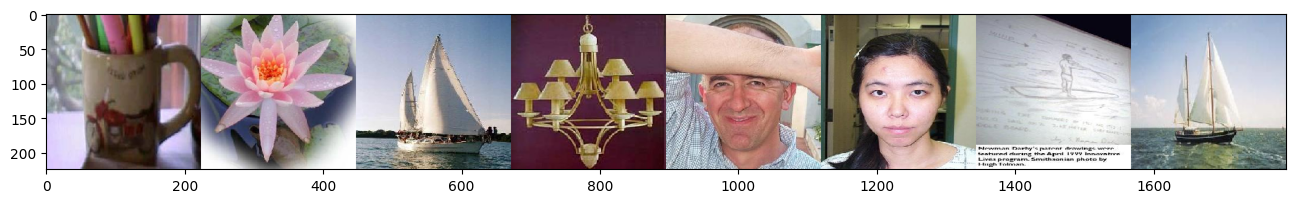

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### Primeiro treinando uma rede neural do zero

Antes de fazer a transfer learning, vamos primeiro construir uma rede neural do zero para fazer a classificação em nosso conjunto de dados. Isso nos dará uma linha de base para comparar com nossa rede transferida posteriormente.

A rede que construiremos contém 4 camadas convolucionais e de max-pooling alternadas, seguidas por um dropout após cada par de convolução/pooling. Após a última camada de pooling, vamos anexar uma camada totalmente conectada com 256 neurônios, outra camada de dropout e, finalmente, uma camada de classificação softmax para nossas classes.

Nossa função de perda será, como de costume, a perda de entropia cruzada categórica, e nosso algoritmo de aprendizado será AdaDelta. Várias coisas sobre esta rede podem ser alteradas para obter um melhor desempenho, talvez usar uma rede maior ou um otimizador diferente ajude, mas para os propósitos deste notebook, o objetivo é apenas obter uma compreensão de uma linha de base aproximada para fins de comparação, então não é necessário gastar muito tempo tentando otimizar esta rede.

Ao compilar a rede, vamos executar model.summary() para obter uma visão geral de suas camadas.

In [ ]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                  

Criamos uma rede de tamanho médio com cerca de ~1,2 milhões de pesos e viéses (os parâmetros). A maioria deles está indo para a camada totalmente conectada "dense_5" antes do softmax.

Agora podemos prosseguir e treinar nosso modelo por 100 épocas com um tamanho de lote de 128. Também registraremos seu histórico para que possamos plotar a perda ao longo do tempo depois.

In [ ]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Vamos plotar a perda de validação e a precisão de validação ao longo do tempo.








NameError: name 'history' is not defined

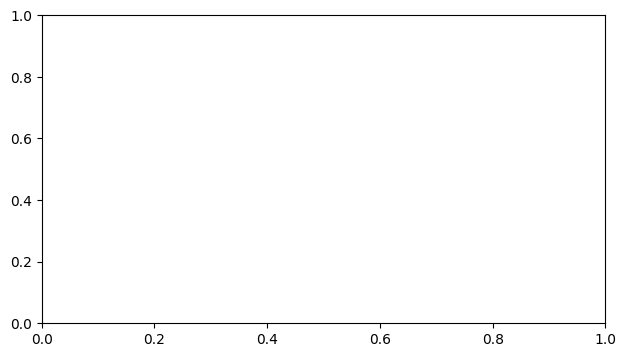

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_acc"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Perceba que a perda de validação começa a aumentar realmente após cerca de 16 épocas, mesmo que a precisão de validação permaneça aproximadamente entre 40% e 50%. Isso sugere que nosso modelo começa a sofrer overfitting por volta desse ponto, e o melhor desempenho teria sido alcançado se tivéssemos parado mais cedo. No entanto, nossa precisão provavelmente não teria sido acima de 50%, e provavelmente seria ainda mais baixa.

Também podemos obter uma avaliação final executando nosso modelo no conjunto de treinamento. Fazendo isso, obtemos os seguintes resultados:

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 2.6905115888865723
Test accuracy: 0.4034334763948498


*Finally*, Conseguimos uma precisão (top-1) de cerca de 49%. Isso não é tão ruim para 6000 imagens, considerando que se usássemos uma estratégia ingênua de fazer suposições aleatórias, teríamos obtido apenas cerca de 1% de precisão.

##Transfer learning começando com uma rede existente
Agora podemos prosseguir para a principal estratégia para treinar um classificador de imagens em nosso pequeno conjunto de dados: começando com uma rede maior e já treinada.

Para começar, vamos carregar o VGG16 do keras, que foi treinado no ImageNet e os pesos salvos online. Se esta for a primeira vez que você carrega o VGG16, precisará esperar um pouco para que os pesos sejam baixados da web. Uma vez que a rede esteja carregada, podemos novamente inspecionar as camadas com o método summary()

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467904/553467096 [==============================] - 7s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_po

Observe que o VGG16 é muito maior do que a rede que construímos anteriormente. Ele contém 13 camadas convolucionais e duas camadas totalmente conectadas no final, e possui mais de 138 milhões de parâmetros, cerca de 100 vezes mais parâmetros do que a rede que fizemos acima. Assim como nossa primeira rede, a maioria dos parâmetros está armazenada nas conexões que levam à primeira camada totalmente conectada.

O VGG16 foi criado para resolver o ImageNet e alcança uma taxa de erro de 8,8% no top-5, o que significa que 91,2% das amostras de teste foram classificadas corretamente dentro das 5 principais previsões para cada imagem. Sua precisão no top-1 - equivalente à métrica de precisão que usamos (que a principal previsão está correta) - é de 73%. Isso é especialmente impressionante, pois não há apenas 97, mas 1000 classes, o que significa que palpites aleatórios nos dariam apenas 0,1% de precisão.

Para usar essa rede para nossa tarefa, "removemos" a camada de classificação final, a camada softmax de 1000 neurônios no final, que corresponde ao ImageNet, e a substituímos por uma nova camada softmax para nosso conjunto de dados, que contém 97 neurônios no caso do conjunto de dados 101_ObjectCategories.

Em termos de implementação, é mais fácil simplesmente criar uma cópia do VGG a partir de sua camada de entrada até a penúltima camada e, em seguida, trabalhar com isso, em vez de modificar diretamente o objeto VGG. Portanto, tecnicamente nunca "removemos" nada, apenas o contornamos/ignoramos. Isso pode ser feito da seguinte maneira, usando a classe Model do Keras para inicializar um novo modelo cujo layer de entrada é o mesmo que o VGG, mas cujo layer de saída é nossa nova camada softmax, chamada new_classification_layer. Observação: embora pareça que estamos duplicando essa grande rede, internamente o Keras está apenas copiando todas as camadas por referência, e, portanto, não precisamos nos preocupar com sobrecarregar a memória.

In [ ]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Vamos retreinar essa rede, `model_new`, no novo conjunto de dados e rótulos. Mas primeiro, precisamos congelar os pesos e vieses em todas as camadas da rede, exceto a nossa nova camada no final, com a expectativa de que as características que foram aprendidas no VGG ainda sejam bastante relevantes para a nova tarefa de classificação de imagens. Não é o ideal, mas provavelmente melhor do que o que podemos treinar em nosso conjunto de dados limitado.

Ao definir o sinalizador `trainable` como falso em cada camada (exceto nossa nova camada de classificação), garantimos que todos os pesos e vieses nessas camadas permaneçam fixos, e simplesmente treinamos os pesos na única camada no final. Em alguns casos, é desejável *não* congelar todas as camadas pré-classificação. Se seu conjunto de dados tiver amostras suficientes e não se parecer muito com o ImageNet, pode ser vantajoso ajustar finamente algumas das camadas do VGG junto com o novo classificador, ou possivelmente todas elas. Para fazer isso, você pode alterar o código abaixo para tornar mais camadas treináveis.

No caso do CalTech-101, faremos apenas extração de recursos, temendo que o ajuste fino excessivo com esse conjunto de dados possa levar a overfitting. Mas talvez estejamos errados? Um bom exercício seria tentar ambos e comparar os resultados.

Então, vamos em frente e congelar as camadas, e compilar o novo modelo com exatamente o mesmo otimizador e função de perda que em nossa primeira rede, para fins de uma comparação justa. Em seguida, executamos `summary` novamente para examinar a arquitetura da rede.

In [ ]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Olhando para o resumo, vemos que a rede é idêntica ao modelo VGG que instanciamos anteriormente, exceto pela última camada, anteriormente uma softmax de 1000 neurônios, que foi substituída por uma nova softmax de 97 neurônios. Além disso, ainda temos aproximadamente 134 milhões de pesos, mas agora a grande maioria deles são "parâmetros não treináveis", pois congelamos as camadas em que eles estão contidos. Agora temos apenas 397.000 parâmetros treináveis, o que é na verdade apenas um quarto do número de parâmetros necessários para treinar o primeiro modelo.

Como antes, vamos em frente e treinar o novo modelo, usando os mesmos hiperparâmetros (tamanho do lote e número de épocas) de antes, juntamente com o mesmo algoritmo de otimização. Também manteremos o registro de seu histórico durante o processo.

In [ ]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 66s 15ms/step - loss: 4.0574 - acc: 0.1631 - val_loss: 3.1996 - val_acc: 0.3040
Epoch 2/10
4346/4346 [==============================] - 46s 11ms/step - loss: 2.5812 - acc: 0.4441 - val_loss: 2.3154 - val_acc: 0.5070
Epoch 3/10
4346/4346 [==============================] - 46s 11ms/step - loss: 1.9747 - acc: 0.5630 - val_loss: 1.9155 - val_acc: 0.5585
Epoch 4/10
4346/4346 [==============================] - 46s 11ms/step - loss: 1.6366 - acc: 0.6305 - val_loss: 1.7621 - val_acc: 0.5768
Epoch 5/10
4346/4346 [==============================] - 46s 11ms/step - loss: 1.4263 - acc: 0.6795 - val_loss: 1.5046 - val_acc: 0.6681
Epoch 6/10
4346/4346 [==============================] - 46s 11ms/step - loss: 1.2610 - acc: 0.7098 - val_loss: 1.4539 - val_acc: 0.6477
Epoch 7/10
4346/4346 [==============================] - 46s 11ms/step - loss: 1.1283 - acc: 0.7407 - val_loss: 1.3778 - val_acc: 0.6778
E

Nossa precisão de validação fica próxima de 80% no final, o que representa uma melhoria de mais de 30% em relação à rede original treinada do zero (significando que fazemos a previsão errada em 20% das amostras, em vez de 50%).

Vale notar também que essa rede treina _ligeiramente mais rápido_ do que a rede original, apesar de ter mais de 100 vezes mais parâmetros! Isso porque congelar os pesos nega a necessidade de retropropagar através de todas essas camadas, economizando tempo de execução.

Vamos traçar o gráfico da perda de validação e da precisão novamente, desta vez comparando o modelo original treinado do zero (em azul) e o novo modelo de transferência de aprendizado em verde.

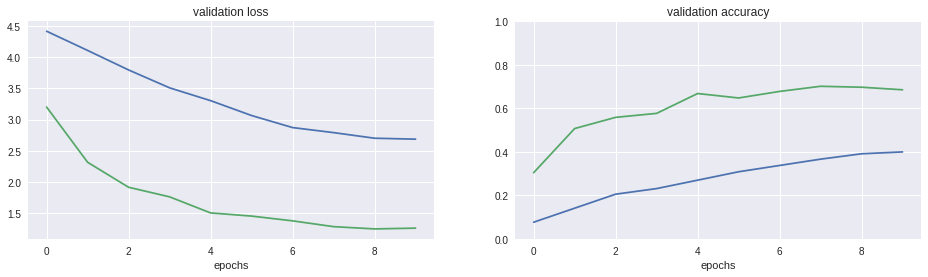

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_acc"])
ax2.plot(history2.history["val_acc"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que, enquanto o modelo original começou a apresentar overfitting por volta da época 16, o novo modelo continuou a diminuir lentamente sua perda ao longo do tempo e provavelmente teria melhorado sua precisão ligeiramente com mais iterações. O novo modelo chegou a aproximadamente 80% de precisão no top-1 (no conjunto de validação) e continuou a melhorar lentamente até a época 100.

É possível que tivéssemos melhorado o modelo original com uma melhor regularização ou mais dropout, mas certamente não teríamos compensado a melhoria de >30% na precisão.

Novamente, fazemos uma validação final no conjunto de teste.

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.1540323304004423
Test accuracy: 0.7156652360515021


Para prever uma nova imagem, basta executar o seguinte código para obter as probabilidades de cada classe:

In [ ]:
img, x = get_image('101_ObjectCategories/airplanes/image_0003.jpg')
probabilities = model_new.predict([x])


0.6425913


### Melhorando os resultados

78,2% de precisão no top-1 em 97 classes, aproximadamente distribuídas uniformemente, é uma conquista bastante boa. Não é tão impressionante quanto o VGG16 original, que alcançou 73% de precisão no top-1 em 1000 classes. No entanto, é muito melhor do que o que conseguimos com nossa rede original, e há espaço para melhorias. Algumas técnicas que possivelmente poderiam ter melhorado nosso desempenho:

- Usar aumento de dados (data augmentation): o aumento de dados se refere ao uso de várias modificações dos dados de treinamento originais, na forma de distorções, rotações, redimensionamentos, mudanças de iluminação, etc., para aumentar o tamanho do conjunto de treinamento e criar mais tolerância a tais distorções.
- Usar um otimizador diferente, adicionar mais regularização/dropout e outros hiperparâmetros.
- Treinar por mais tempo (é claro)

Um exemplo mais avançado de transferência de aprendizado no Keras, envolvendo aumento de dados para um pequeno conjunto de dados de 2 classes, pode ser encontrado no [blog do Keras](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).